# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import randint
from xgboost import XGBClassifier

# install ucimlrepo (only once in Colab)
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo


# 2. Load Dataset

In [2]:
 # fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)


{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

# EDA

In [3]:
print("Shape:", X.shape)
print("\nInfo:")
print(X.info())
print("\nDescribe:")
print(X.describe().T.head(10))

Shape: (581012, 54)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Soil_Type1               

In [4]:
y = y.squeeze()

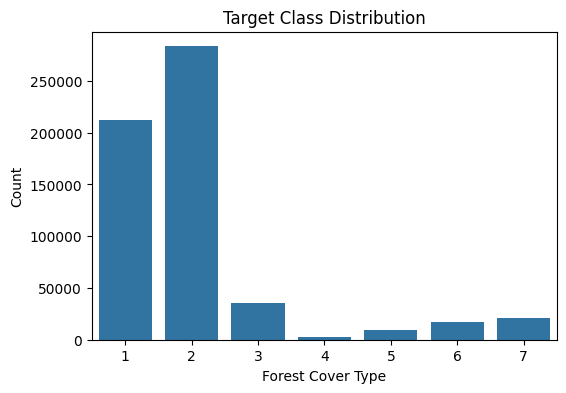

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.xlabel("Forest Cover Type")
plt.ylabel("Count")
plt.show()


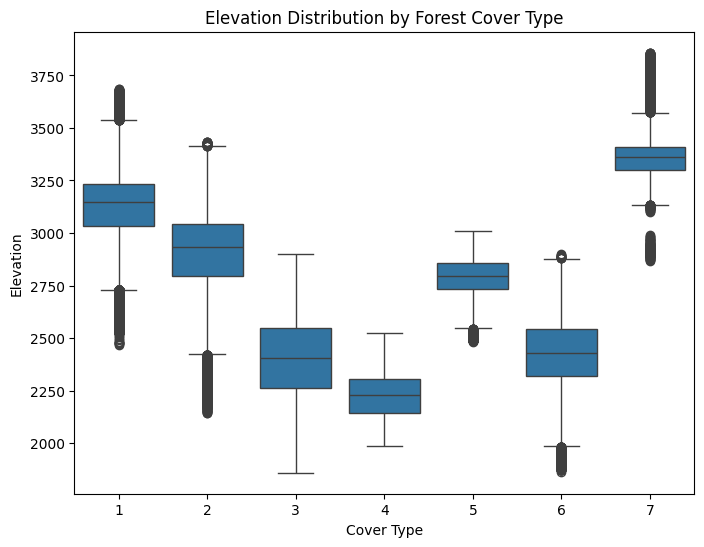

In [6]:
plt.figure(figsize=(8,6))
sns.boxplot(x=y, y=X["Elevation"])
plt.title("Elevation Distribution by Forest Cover Type")
plt.xlabel("Cover Type")
plt.ylabel("Elevation")
plt.show()


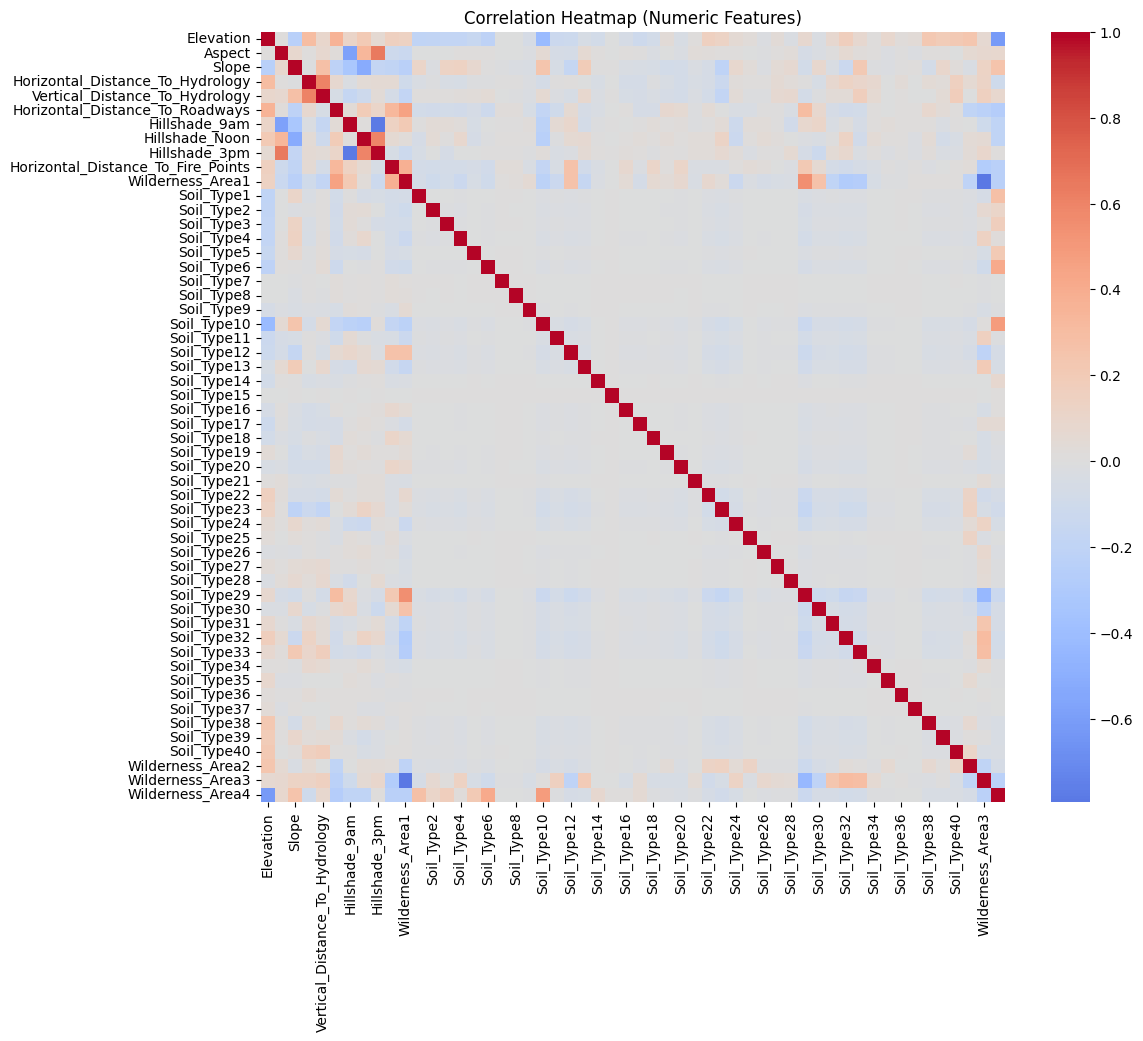

In [7]:
num_cols = X.select_dtypes(include="number").columns
plt.figure(figsize=(12,10))
sns.heatmap(X[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


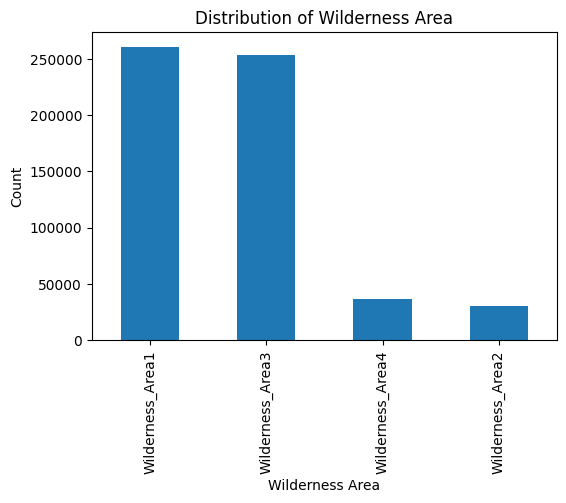

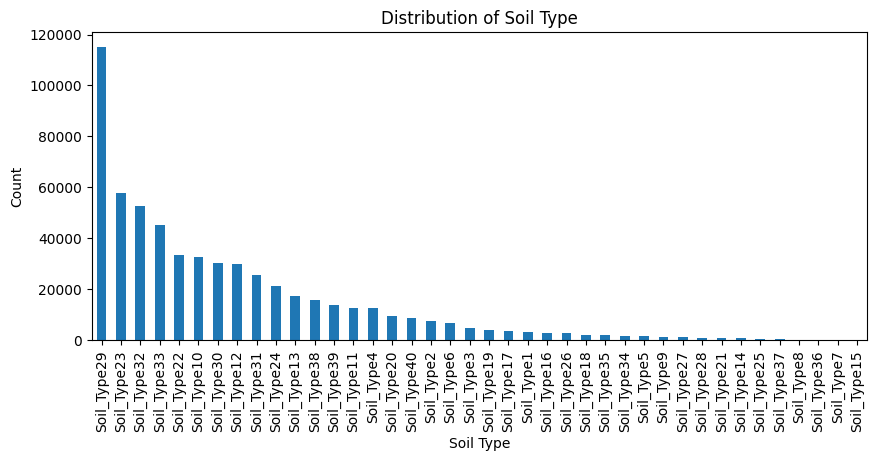

In [8]:
wilderness_cols = [col for col in X.columns if "Wilderness" in col]
soil_cols = [col for col in X.columns if "Soil_Type" in col]

# Wilderness
plt.figure(figsize=(6,4))
X[wilderness_cols].idxmax(axis=1).value_counts().plot(kind="bar")
plt.title("Distribution of Wilderness Area")
plt.xlabel("Wilderness Area")
plt.ylabel("Count")
plt.show()

# Soil Type
plt.figure(figsize=(10,4))
X[soil_cols].idxmax(axis=1).value_counts().plot(kind="bar")
plt.title("Distribution of Soil Type")
plt.xlabel("Soil Type")
plt.ylabel("Count")
plt.show()


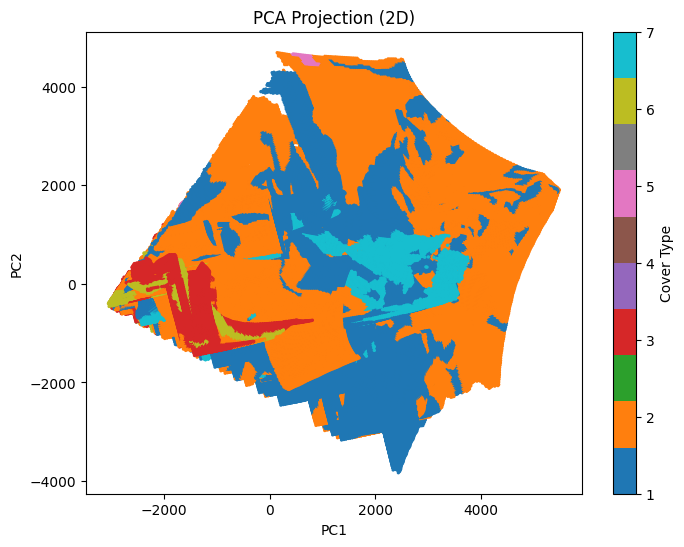

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", s=2)
plt.title("PCA Projection (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cover Type")
plt.show()


# Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


# Train Model (Random Forest)

In [11]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

# Evaluation

Accuracy: 0.9538824298856312

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.91      0.85      0.88       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



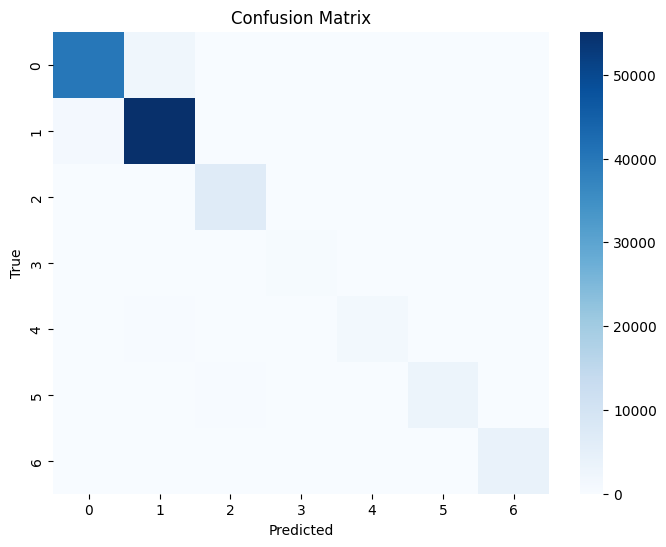

In [12]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


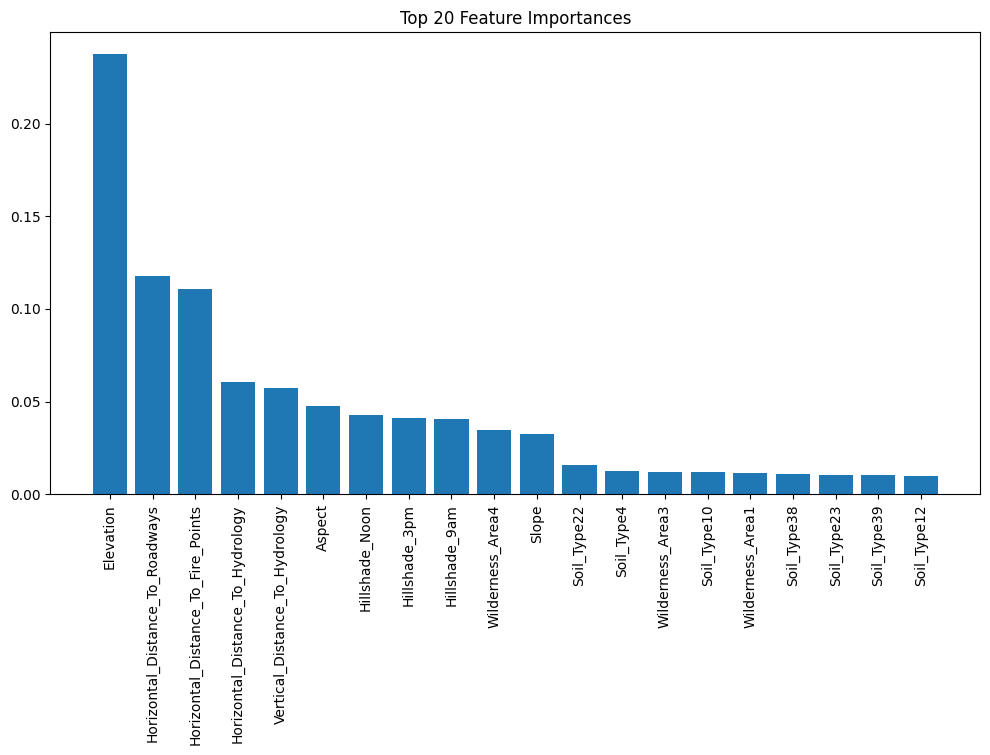

In [13]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(20), importances[indices[:20]], align="center")
plt.xticks(range(20), X.columns[indices[:20]], rotation=90)
plt.title("Top 20 Feature Importances")
plt.show()


# Compare Random Forest and XGBoost

In [14]:
from sklearn.preprocessing import LabelEncoder

# Re-encode y for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (RF):\n", classification_report(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)
xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print("\nClassification Report (XGB):\n", classification_report(y_test_enc, y_pred_xgb))


Random Forest Accuracy: 0.9538824298856312

Classification Report (RF):
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.91      0.85      0.88       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203

XGBoost Accuracy: 0.8961386539073862

Classification Report (XGB):
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     42368
           1       0.89      0.92      0.91     56661
           2       0.92      0.93      0.92      7151
           3       0.90      0.87      0.88  